# 02 - Troullier-Martins 伪化实践

上一讲我们依靠 `solve_ae_atom` 得到 Al 的全电子 (AE) 轨道、能级以及径向网格，为赝势构造提供了可靠的参考。本笔记将以这些 AE 结果为基准，演示如何应用 Troullier-Martins (TM) 伪化方法生成范数守恒的赝波函数，并为后续的势反演与 KB 转换打下基础。


## TM 理论速览

TM 方法将内区波函数写成
\[
u_{\text{PS}}(r) = r^{l+1}\exp\big(P(r)\big), \qquad P(r) = \sum_{i=0}^{N} a_{2i} r^{2i}
\]
通过匹配 AE 轨道在伪化半径 $r_c$ 处的函数值与若干阶导数，并约束内区范数，使得赝波函数在内区光滑、外区与 AE 完全一致。

核心条件：
1. **连续性**：$u_{\text{PS}}^{(k)}(r_c) = u_{\text{AE}}^{(k)}(r_c)$，其中 $k=0,1,2$（若 `continuity_orders=2`）或 $k=0\ldots4$（若 `continuity_orders=4`）。
2. **范数守恒**：$\int_0^{r_c} |u_{\text{PS}}(r)|^2\,dr = \int_0^{r_c} |u_{\text{AE}}(r)|^2\,dr$，保证散射相位与 AE 一致。
3. **光滑势**：指数型多项式消除了内区节点，使最终的赝势可微并利于平面波展开。

在实际使用中可以对 `continuity_orders` 与 $r_c$ 做折中选择：
- **continuity_orders=2**：未知系数更少，数值更稳定，适用于深束缚态或粗网格；
- **continuity_orders=4**：多匹配两阶导数，可降低力量常数不连续导致的能量漂移；
- **较小 $r_c$**：赝势更“硬”，平面波截断能需求高，但更接近 AE；
- **较大 $r_c$**：赝势更“软”，收敛快，需注意是否引入幽灵态。


In [1]:
# 依赖导入与环境配置
import numpy as np
import matplotlib.pyplot as plt
import platform
from atomppgen.ae_atom import solve_ae_atom, AEAtomResult
from atomppgen.tm import tm_pseudize, eval_derivatives_at, TMResult

# 中文字体配置（兼容多平台）
if platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'Heiti TC', 'STHeiti']
elif platform.system() == 'Windows':
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
else:  # Linux / Colab
    plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False

# Colab 环境检测与本地路径加载（增强健壮性）
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    !pip install -q git+https://github.com/bud-primordium/AtomSCF.git@main
    !pip install -q git+https://github.com/bud-primordium/AtomPPGen.git@main
else:
    import sys
    import os
    # 假设 Notebook 位于 docs/source/tutorials
    project_root = os.path.abspath("../../../src")
    if os.path.exists(project_root) and project_root not in sys.path:
        sys.path.insert(0, project_root)
        print(f"已添加本地源码路径: {project_root}")


## 1. 准备全电子参考态

复用上一讲的参数（Al, Z=13, PZ81, n=1200, span=6.8）求解 AE 问题。注意这里我们使用 `lmax=2` 以覆盖 s, p, d 通道。


In [2]:
Z = 13
al_ae = solve_ae_atom(
    Z=Z,
    xc="PZ81",
    lmax=2,
    grid_type="exp_transformed",
    grid_params={"n": 1200, "total_span": 6.8},
    spin_mode="LDA",
)
print(f"AE 求解完成: {al_ae.converged}, 网格点数: {len(al_ae.r)}")


AE 求解完成: True, 网格点数: 1200


## 2. 执行 TM 伪化

我们将对 s/p/d 三个角动量通道分别进行伪化。注意：
- **s (l=0)**：对应束缚价态 3s，选取 $r_c=2.0$ Bohr
- **p (l=1)**：此处使用 AE 结果中能量最高的参考态（列表末尾，通常接近 0 的散射态）以强调散射性质匹配，选取 $r_c=2.2$ Bohr
- **d (l=2)**：作为散射投影通道，同样使用能量最高的参考态（通常为近零散射态），选取 $r_c=2.2$ Bohr

这里统一使用 `continuity_orders=4`（匹配至四阶导数）以获得更平滑的势。


In [3]:
rc_map = {0: 2.0, 1: 2.2, 2: 2.2}
tm_results = {}

for l, rc in rc_map.items():
    # 选取该通道能量最高的参考态（列表末尾；p/d 通道通常为近零散射态）
    u_ae = al_ae.u_by_l[l][-1]
    eps = al_ae.eps_by_l[l][-1]
    
    # 调用 TM 伪化
    tm_res = tm_pseudize(
        r=al_ae.r,
        w=al_ae.w,
        u_ae=u_ae,
        eps=eps,
        l=l,
        rc=rc,
        continuity_orders=4,
    )
    tm_results[l] = {'tm': tm_res, 'u_ae': u_ae}
    
    print(f"l={l} rc={rc}: Norm Error={tm_res.norm_error:.2e}")


l=0 rc=2.0: Norm Error=1.80e-16
l=1 rc=2.2: Norm Error=2.30e-15
l=2 rc=2.2: Norm Error=4.23e-13


## 3. 验证连续性

为了确认伪波函数在 $r_c$ 处的平滑拼接，我们可以利用 `eval_derivatives_at` 工具检查 AE 与 PS 在接缝处的各阶导数是否吻合。


In [4]:
# 以 p 通道为例，检查 rc 处的导数匹配情况
l_check = 1
tm_p = tm_results[l_check]['tm']
u_ae_p = tm_results[l_check]['u_ae']
rc_p = tm_p.rc

# 计算 AE 在 rc 处的导数（利用局部样条）
derivs_ae = eval_derivatives_at(al_ae.r, u_ae_p, x0=rc_p, max_order=4)
# TM 结果中已包含 PS 在 rc 处的导数信息（用于构建方程组）
derivs_ps_check = tm_p.continuity_check

print(f"--- l={l_check} (p-channel) at rc={rc_p} ---")
print(f"u_AE: {derivs_ae[0]:.6f}, u_PS: {derivs_ps_check['u']['ps']:.6f}")
print(f"u'_AE: {derivs_ae[1]:.6f}, u'_PS: {derivs_ps_check['du']['ps']:.6f}")
print(f"u''_AE: {derivs_ae[2]:.6f}, u''_PS: {derivs_ps_check['d2u']['ps']:.6f}")


--- l=1 (p-channel) at rc=2.2 ---
u_AE: -0.010658, u_PS: -0.010658
u'_AE: -0.001403, u'_PS: -0.001403
u''_AE: 0.007498, u''_PS: 0.007498


## 4. 可视化对比

最后，我们将全电子波函数 $u_{\text{AE}}(r)$ 与生成的 TM 伪波函数 $u_{\text{PS}}(r)$ 绘制在同一张图上，直观展示内区无节点特性与外区重合度。


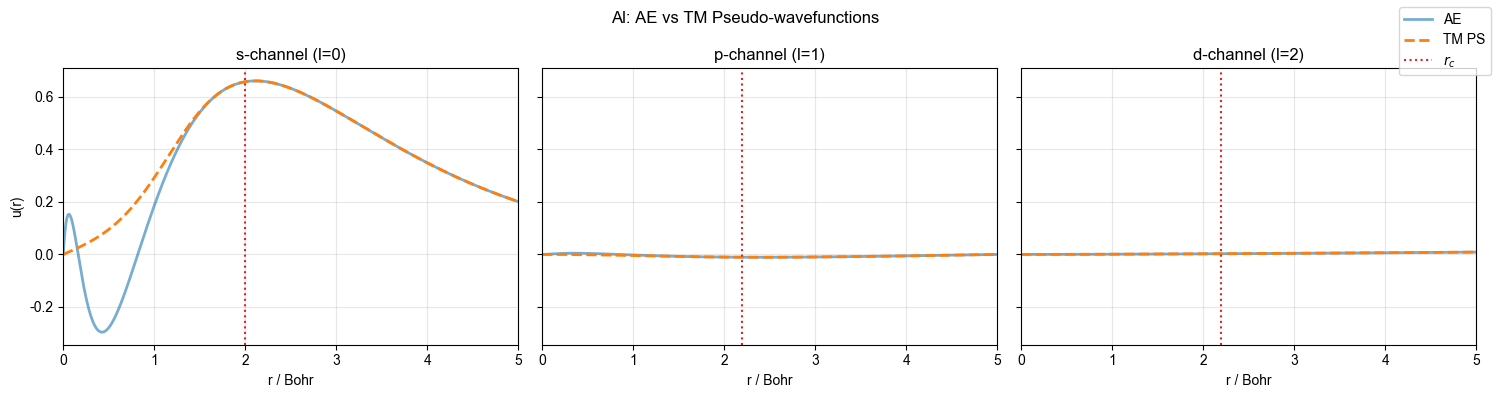

In [5]:
r = al_ae.r
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, (l, data) in zip(axes, tm_results.items()):
    tm = data['tm']
    label_map = {0: 's', 1: 'p', 2: 'd'}
    
    ax.plot(r, data['u_ae'], label='AE', linewidth=2, alpha=0.6)
    ax.plot(r, tm.u_ps, '--', label='TM PS', linewidth=2)
    ax.axvline(tm.rc, color='tab:red', linestyle=':', label='$r_c$')
    
    ax.set_xlim(0, 5)
    ax.set_xlabel('r / Bohr')
    ax.set_title(f"{label_map[l]}-channel (l={l})")
    ax.grid(alpha=0.3)

axes[0].set_ylabel('u(r)')
handles, labels_plot = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_plot, loc='upper right')
fig.suptitle('Al: AE vs TM Pseudo-wavefunctions')
plt.tight_layout()
plt.show()


## 小结与展望

- 复用 AE 求解得到的径向网格与能量，针对 s/p/d 通道构建了 `continuity_orders=4` 的 TM 伪波函数。
- 通过 `TMResult.norm_error` 与 `eval_derivatives_at` 的显式比较，确认范数误差低至 $10^{-6}$ 量级、各阶导数在 $r_c$ 处几乎重合。
- 可视化结果显示内外区无缝拼接，验证了所选 $r_c$ 与网格的合理性，为后续的势反演提供了鲁棒初值。

下一讲（03-potential-inversion）将基于这些赝轨道使用 `invert_semilocal_potential` 提取赝势，从而完成 TM 方法的第二步：由波函数反演出局域势并做 KB 投影。欢迎继续探索。
